In [1]:
# Code thanks to Moses Boudourides, Sergios Lenis & Pantelis Vikatos
# Their version (largely unchanged except for fixing some python 3.5 incompatibilities)
# can be seen here: http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html
import nltk
import os
import re
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import codecs
from textblob import TextBlob
import pandas as pd
import re
%matplotlib inline
%load_ext autoreload

C:\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# Open and read transcripts in NLTK
f1A=codecs.open('../../../private/brainstorming_viz_data/free_group/teamA_part1_divergent.txt', 'r', encoding='utf-8')
f1B=codecs.open('../../../private/brainstorming_viz_data/free_group/teamB_part1_divergent.txt', 'r', encoding='utf-8')
f1C=codecs.open('../../../private/brainstorming_viz_data/free_group/teamC_part1_divergent.txt', 'r', encoding='utf-8')
f1D=codecs.open('../../../private/brainstorming_viz_data/free_group/teamD_part1_divergent.txt', 'r', encoding='utf-8')
f1E=codecs.open('../../../private/brainstorming_viz_data/free_group/teamE_part1_divergent.txt', 'r', encoding='utf-8')
f1F=codecs.open('../../../private/brainstorming_viz_data/free_group/teamF_part1_divergent.txt', 'r', encoding='utf-8')
f1G=codecs.open('../../../private/brainstorming_viz_data/free_group/teamG_part1_divergent.txt', 'r', encoding='utf-8')
f1H=codecs.open('../../../private/brainstorming_viz_data/free_group/teamH_part1_divergent.txt', 'r', encoding='utf-8')
f1I=codecs.open('../../../private/brainstorming_viz_data/free_group/teamI_part1_divergent.txt', 'r', encoding='utf-8')

f2J1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamJ_part1_divergent.txt', 'r', encoding='utf-8')
f2J2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamJ_part3_divergent.txt', 'r', encoding='utf-8')
f2K1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamK_part1_divergent.txt', 'r', encoding='utf-8')
f2K2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamK_part3_divergent.txt', 'r', encoding='utf-8')
f2L1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamL_part1_divergent.txt', 'r', encoding='utf-8')
f2L2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamL_part3_divergent.txt', 'r', encoding='utf-8')
f2M1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamM_part1_divergent.txt', 'r', encoding='utf-8')
f2M2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamM_part2_3_convergent_divergent.txt', 'r', encoding='utf-8')
f2N1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamN_part1_divergent.txt', 'r', encoding='utf-8')
f2N2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamN_part3_divergent.txt', 'r', encoding='utf-8')
f2O1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamO_part1_divergent.txt', 'r', encoding='utf-8')
f2O2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamO_part2_3_conv_div.txt', 'r', encoding='utf-8')
f2P1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamP_part1_divergent.txt', 'r', encoding='utf-8')
f2P2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamP_part3_divergent.txt', 'r', encoding='utf-8')
f2Q1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamQ_part1_divergent.txt', 'r', encoding='utf-8')
f2Q2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamQ_part3_4_div_conv.txt', 'r', encoding='utf-8')
f2R1=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamR_part1_divergent.txt', 'r', encoding='utf-8')
f2R2=codecs.open('../../../private/brainstorming_viz_data/d-c_group/teamR_part3_divergent.txt', 'r', encoding='utf-8')

f1Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f2Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f1Temp.write('free_group/teamA_part1_divergent_bak.txt')
f2Temp.write('free_group/teamA_part1_convergent_bak.txt')
group1_divergent_raw = f1A.read() + f1B.read() + f1C.read() + f1D.read() + f1E.read() + \
                       f1F.read() + f1G.read() + f1H.read() + f1I.read()
group2_divergent_raw = f2J1.read() + f2J2.read() + f2K1.read() + f2K2.read() + f2L1.read() + f2L2.read() + \
                       f2M1.read() + f2M2.read() + f2N1.read() + f2N2.read() + f2O1.read() + f2O2.read() + \
                       f2P1.read() + f2P2.read() + f2Q1.read() + f2Q2.read() + f2R1.read() + f2R2.read() 
regex = re.compile(".*?\\[(.*?)\\]")

def removeObservations(test_str):
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

group1_divergent = removeObservations(group1_divergent_raw)
group2_divergent = removeObservations(group2_divergent_raw)

In [3]:
# Extract Noun phrases using TextBlob
blobFreeGroup = TextBlob(group1_divergent)
blobDCGroup = TextBlob(group2_divergent)
nounFreeGroup = dict(blobFreeGroup.np_counts)
nounDCGroup = dict(blobDCGroup.np_counts)

# convert the above dicts to tupes, order them in descending order of frequency
import operator
nounFreeGrp_tuple = sorted(nounFreeGroup.items(), key=operator.itemgetter(1), reverse=True)
nounDCGrp_tuple = sorted(nounDCGroup.items(), key=operator.itemgetter(1), reverse=True)

#Then convert them back to dicts
from collections import OrderedDict
nounFreeGroupSorted = OrderedDict(nounFreeGrp_tuple)
nounDCGroupSorted = OrderedDict(nounDCGrp_tuple)

dfnp1 = pd.DataFrame(columns=['Noun phrases in Divergent phase Free Group', 'Frequencies'])
dfnp2 = pd.DataFrame(columns=['Noun phrases in Divergent phase D-C Group', 'Frequencies'])
u=1
for i in nounFreeGroupSorted:
    dfnp1.loc[u] = [i, nounFreeGroupSorted[i]]
    u+=1

u=1
for i in nounDCGroupSorted:
    dfnp2.loc[u] = [i, nounDCGroupSorted[i]]
    u+=1
    
print("The total number of noun phrases in the Free Group's divergent phase:", len(nounFreeGroupSorted))
dfnp1.head(25)

The total number of noun phrases in the Free Group's divergent phase: 2028


,Noun phrases in Divergent phase Free Group,Frequencies
1,yeah,691.0
2,oh,203.0
3,it’s,152.0
4,okay,134.0
5,i’m,123.0
6,that’s,114.0
7,well,93.0
8,gon na,85.0
9,let’s,39.0
10,mm-hmm,38.0


In [4]:
print("The total number of noun phrases in the convergent phase:", len(nounDCGroupSorted))
dfnp2.head(25)

The total number of noun phrases in the convergent phase: 1728


,Noun phrases in Divergent phase D-C Group,Frequencies
1,yeah,533.0
2,okay,186.0
3,oh,150.0
4,it’s,119.0
5,that’s,95.0
6,i’m,75.0
7,gon na,41.0
8,alright,38.0
9,well,35.0
10,that’d,32.0


In [5]:
# Common noun phrases in both phases
common = {}
notcommon = {}
dfc = pd.DataFrame(columns=["Common noun phrases", "Free Group", "D-C Group"])
u=1
for i in nounFreeGroupSorted:
    if i in nounDCGroupSorted:
        common[i] = min(nounFreeGroupSorted[i], nounDCGroupSorted[i])
        notcommon[i] = (nounFreeGroupSorted[i], nounDCGroupSorted[i])
        dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
        
dfc

,Common noun phrases,Free Group,D-C Group
1,yeah,691.0,533.0
2,oh,203.0,150.0
3,it’s,152.0,119.0
4,okay,134.0,186.0
5,i’m,123.0,75.0
6,that’s,114.0,95.0
7,well,93.0,35.0
8,gon na,85.0,41.0
9,let’s,39.0,15.0
10,mm-hmm,38.0,28.0


In [6]:
print(common)

{'bottle': 1, 'tootsie roll': 2, 'new toys': 1, 'wow': 3, 'co2': 3, 'remember': 3, 'exactly': 5, 'balls': 1, 'what’s': 16, 'obviously': 2, 'somehow': 2, 'it’d': 8, 'youtube': 1, 'good idea': 8, 'either': 1, 'okay': 134, 'action figure': 2, 'trains': 1, 'making': 2, 'rube goldberg': 2, 'that’s gon na': 1, 'exploding': 1, 'push': 1, 'draw': 3, 'rancher': 2, 'everyone': 1, 'suction cups': 1, 'robots': 3, 'adult toy': 1, 'pez': 9, 'someone': 1, 'right': 18, 'easy ones': 1, 'senior design': 1, 'sort': 1, 'somebody': 1, 'fun toy': 1, 'gon na end': 1, 'say': 5, 'high school': 2, 'well': 35, 'wars': 2, 'gon na shoot': 1, 'try': 3, 'back flip': 1, 'final concept': 2, 'funny thing': 1, 'fish': 1, 'doesn’t': 3, 'elephant': 1, 'mechanical motion': 1, 'bath toy': 1, 'cool': 2, 'cool idea': 1, 'frisbee': 8, 'i’m': 75, 'candy': 1, 'pull': 1, 'wait': 9, 'shit ton': 1, 'little': 1, 'rock': 3, 'god': 3, 't-rex': 1, 'kinda': 1, 'who': 5, 'different things': 5, 'where’d': 1, 'sorry': 8, "n't need": 1, 'no

In [7]:
# Noun phrases that can be removed:
to_be_removed = ['you’ve', "'m gon na", 'everyone', 'your', 'here’s', 
                 'where’d', 'sure', 'nope', 'kinda', 'i’d', 'anyway', 
                 'yep', 'dude', 'type thing', 'we’d', 'sorry', 'unless', 
                 'don’t wan na', 'somebody', 'don’t', 'they’ve', 
                 'it’s gon na', 'you’ll', 'it’s awesome', 'ours', 
                 'they’ll', 'pretty legit', 'have—i don’t', 'someone', 
                 'really', 'you’d', 'say', 'think', 'isn’t', 'going', 
                 'whoa', "'s gon na", 'we’re gon na', 'certain amount', 
                 'dang', 'shit ton', 'does', 'cool', 'basically', 
                 'wouldn’t', 'wow', 'got', 'exact thing', 'bastards', 
                 'wait', 'gon na —', 'sounds', 'great idea', 'doesn’t', 
                 'either', 'it’ll', 'absolutely', 'obviously', 
                 'whole thing', 'i’ve', 'actual ideas', 'sort of—', 
                 'hey', 'uh', 'we’ve', 'that’s gon na', 'he’s', 
                 'sure that’s', 'entire thing', 'it’s kind', 'kind', 
                 'sort', 'iu', 'we’ll', 'real thing', 'cuz it’s', 'ow', 
                 'nice', 'definitely', 'pretty sweet', 'gotcha', 'it’d', 
                 'was', 'gon na look', 'hm', 'ooh', 'wan na pin', 
                 'a—some sort', "'s like—", 'be'] 

keys_to_delete = []
for key in common.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del common[key] # could not have deleted item from iterable 
                    # from within the loop
ccommon=common.keys()

In [8]:
# Function to count co-occurrences of common noun phrases in sentences
def occurrences(source, terms):
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms = list(itertools.combinations(terms,2)) # NC2 of terms
    n = len(combinations_terms)
    occurlist = []
    for i in range(1, n):
        for j in ALL_sentences:
            temp = list(combinations_terms[i])
            # Find every combination of term 1 followed by term 2 in
            # term pair (1,2)
            out=re.compile(str(temp[0]) + '(.*?)' + str(temp[1]), 
                           re.DOTALL | re.IGNORECASE).findall(j)
            if out:
                occurlist.append(str(temp[0]) + ' - ' + str(temp[1]))
            # Find every combination of term 2 followed by term 1 in
            # term pair (1,2)
            out2 = re.compile(str(temp[1]) + '(.*?)' + str(temp[0]),
                             re.DOTALL | re.IGNORECASE).findall(j)
            if out2:
                occurlist.append(str(temp[1]) + ' - ' + str(temp[0]))
    occurdict = {}
    # count occurrences of term pairs
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else : 
            occurdict[i] = occurdict[i] + 1
    return occurdict

# Call function to find divergent and convergent terms
FreeDivdict = occurrences(group1_divergent, ccommon)
DCDivdict = occurrences(group2_divergent, ccommon)
# nounDivdict = dict(nounDiv)
# nounConvdict = dict(nounConv)
# Divdict = occurrences(divergent, nounDiv)
# Convdict = occurrences(convergent, nounConv)

In [9]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(FreeDivdict)
DCGraphData = makegraph(DCDivdict)
GFree = FreeGraphData[0]
GDC = DCGraphData[0]
FreeEdges = FreeGraphData[1]
DCEdges = DCGraphData[1]

In [10]:
print(GFree.edges(data=True))

[('bottle', 'i’m', {'weight': 1}), ('bottle', 'rock', {'weight': 3}), ('tootsie roll', 'making', {'weight': 1}), ('tootsie roll', 'we’re', {'weight': 1}), ('tootsie roll', 'pick', {'weight': 1}), ('tootsie roll', 'have', {'weight': 1}), ('different gear ratios', 'different', {'weight': 1}), ('different gear ratios', 'they’re', {'weight': 1}), ('different gear ratios', 'spin', {'weight': 1}), ('different motors', 'have', {'weight': 1}), ('fun game', 'what’s', {'weight': 1}), ('co2', 'have', {'weight': 1}), ('co2', 'yeah', {'weight': 1}), ('co2', 'let’s', {'weight': 1}), ('co2', 'who', {'weight': 1}), ('co2', 'power', {'weight': 3}), ('remember', 'try', {'weight': 1}), ('remember', 'different', {'weight': 1}), ('remember', 'looks', {'weight': 1}), ('remember', 'have', {'weight': 1}), ('remember', 'well', {'weight': 1}), ('remember', 'they’re', {'weight': 2}), ('remember', 'push', {'weight': 1}), ('remember', 'it’s', {'weight': 1}), ('remember', 'yeah', {'weight': 1}), ('remember', 'bop',

In [11]:
print(GDC.edges(data=True))

[('funny thing', 'it’s', {'weight': 1}), ('funny thing', 'yeah', {'weight': 1}), ('funny thing', 'have', {'weight': 1}), ('bottle', 'we’re', {'weight': 1}), ('bottle', 'little', {'weight': 1}), ('different gear ratios', 'yeah', {'weight': 1}), ('different gear ratios', 'cuz', {'weight': 1}), ('new toys', 'right', {'weight': 1}), ('own way', 'have', {'weight': 1}), ('co2', 'it’s', {'weight': 1}), ('remember', 'kids', {'weight': 1}), ('remember', 'have', {'weight': 1}), ('remember', 'pull', {'weight': 1}), ('remember', 'push', {'weight': 1}), ('remember', 'exactly', {'weight': 1}), ('remember', 'little', {'weight': 1}), ('remember', 'hovercraft', {'weight': 1}), ('remember', 'rc', {'weight': 1}), ('remember', 'cuz', {'weight': 2}), ('remember', 'who', {'weight': 1}), ('remember', 'kids cuz', {'weight': 1}), ('remember', 'it’s', {'weight': 1}), ('remember', 'power', {'weight': 1}), ('balls', 'that’s', {'weight': 1}), ('balls', 'plastic', {'weight': 1}), ('balls', 'shoots', {'weight': 1}),

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


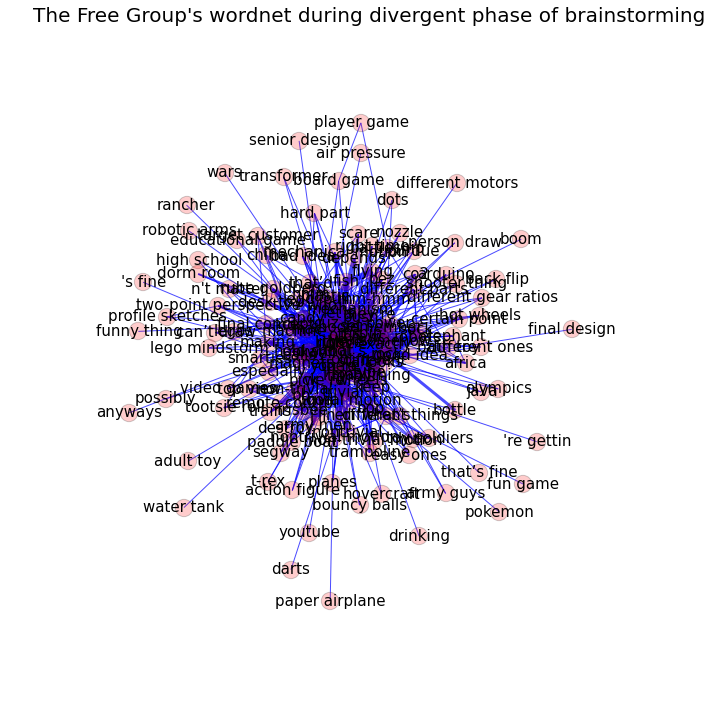

In [14]:
# Plot graph of common phrases in Team A's divergent phase
from tools import draw_network
pos = nx.spring_layout(GFree, iterations=20)
sstt="The Free Group's wordnet during divergent phase of brainstorming"
possit=draw_network(GFree,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


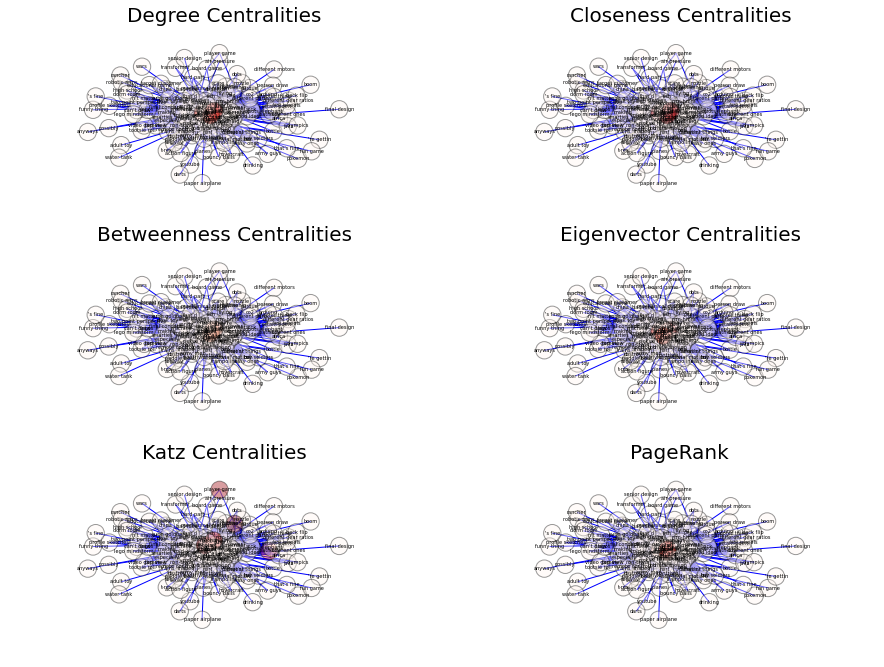

In [15]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

In [16]:
# Table of centralities of common phrases in the graph
dfcdiv = pd.DataFrame()
# The rest needs to be sorted out; version incompatibility

Number of communities of  The Free Group's wordnet during divergent phase of brainstorming  =  5
Community partition of  The Free Group's wordnet during divergent phase of brainstorming :
[['bottle', 'somehow', 'robots', 'pez', 'fish', 'looks', 'elephant', 'mechanical motion', 'pull', 'rock', 'shoot', 'action figure', 'shoots', 'certain point', 'that’d', 'desk toy', 'darts', 'off', 'hard part', 'africa', 'dorm room', 'sock', 'flying', 'nerf', 'bb', 'water tank', 'arduino', 'type', 'different parts', 'trampoline'], ['tootsie roll', 'what’s', 'good idea', 'okay', 'making', 'draw', 'pokemon', 'well', 'final concept', 'high school', 'two-point perspective', 'i’m', 'frisbee', 'nontrivial', "n't matter", 'adult toy', 'we’re', 'that’s', 'final design', 'i’ll', 'nontrivial motion', 'target customer', 'fun game', 'can’t draw', 'top view', 'trivial motion', 'hovercraft', 'person draw', 't-rex', 'non-trivial', 'pick', 'trivial', 'smarties', 'java', 'different ones', 'paddle boat', 'huh', 'educati

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


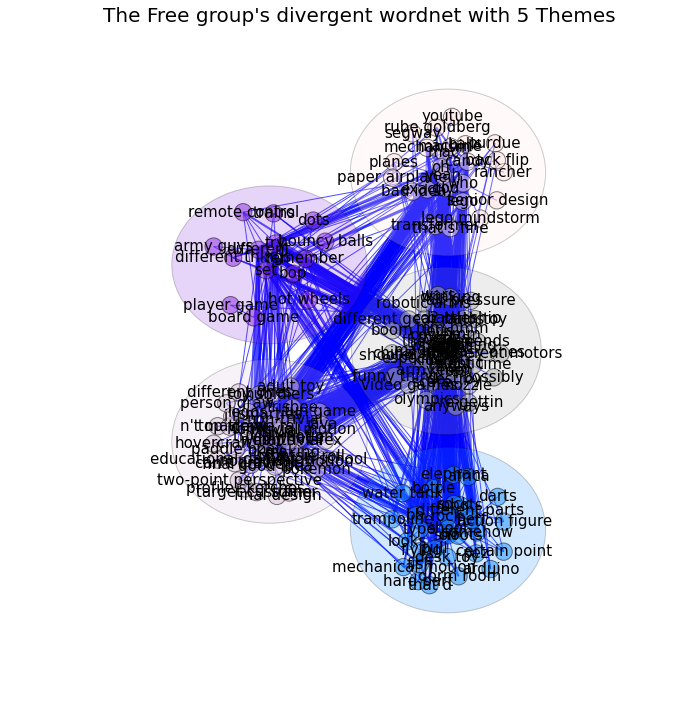

In [17]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="The Free group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


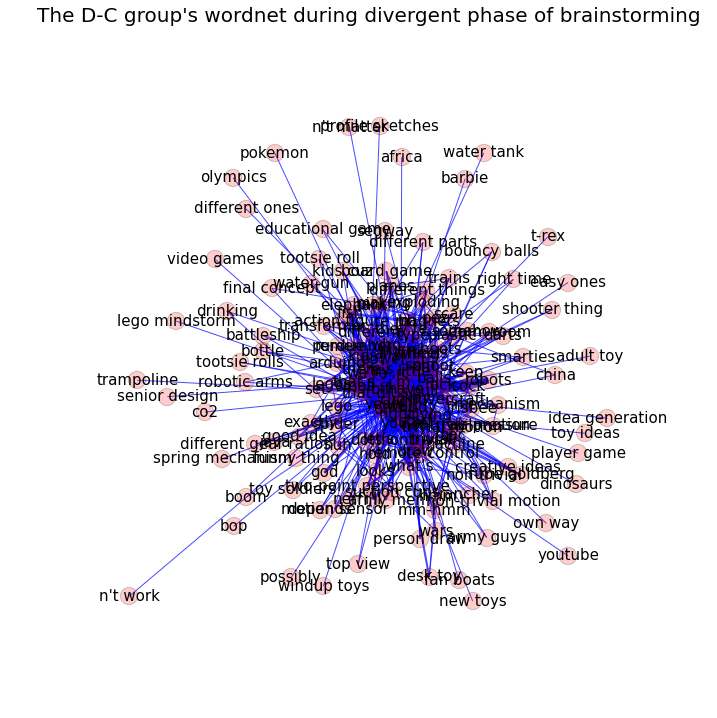

In [18]:
# Plot graph of common phrases in Team A's convergent phase
from tools import draw_network
pos = nx.spring_layout(GDC, iterations=20)
sstt="The D-C group's wordnet during divergent phase of brainstorming"
possit=draw_network(GDC,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


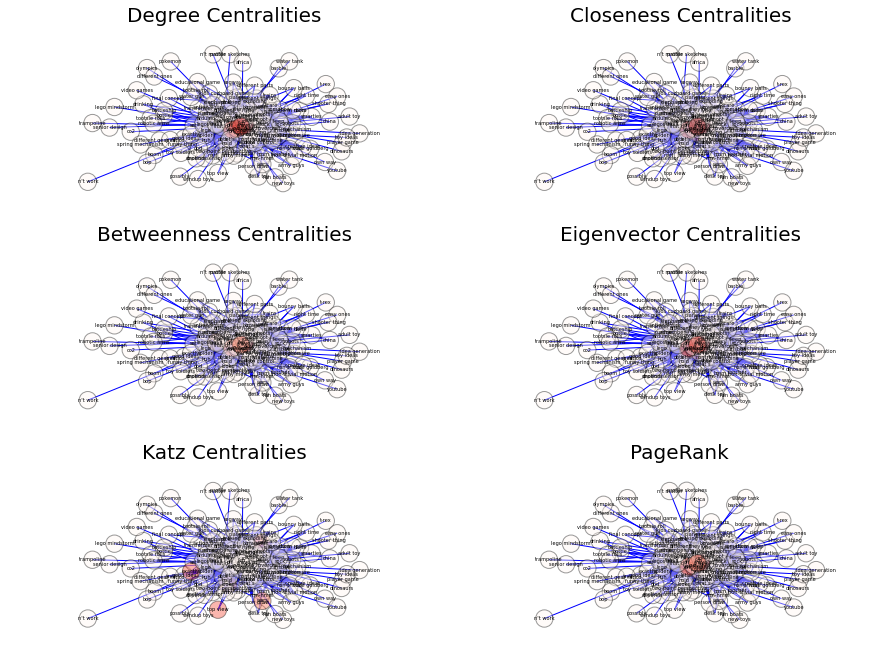

In [19]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GDC, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

Number of communities of  Team A Divergent vs. Convergent wordnet 
 Divergent edges are cyan, Convergent edges are green and common edges are red  =  8
Community partition of  Team A Divergent vs. Convergent wordnet 
 Divergent edges are cyan, Convergent edges are green and common edges are red :
[['funny thing', 'co2', 'good idea', 'rancher', 'pokemon', 'tootsie rolls', 'final concept', 'fish', 'elephant', 'spider', 'army men', 'set', 'that’s', 'remote control', 'lego', 'planes', 'video games', 'tootsie roll', 'drinking', 'barbie', 'pick', 'player game', 'it’s', 'flying', 'there’s', 'adult toy', 'army guys', 'robotic arms', 'trampoline', 'profile sketches', 'anything', 'senior design', 'kids', 'legos', 'lego mindstorm'], ['bottle', 'action figure', 'exploding', 'pez', 'well', 'shoot', 'we’re', 'right time', 'shoots', 'nontrivial motion', 'darts', 'olympics', 'creative ideas', 'smarties', 'shooter thing', 'keep'], ['rube goldberg', 'mm-hmm', 'candy', 'god', 'windup toys', 'motion senso

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


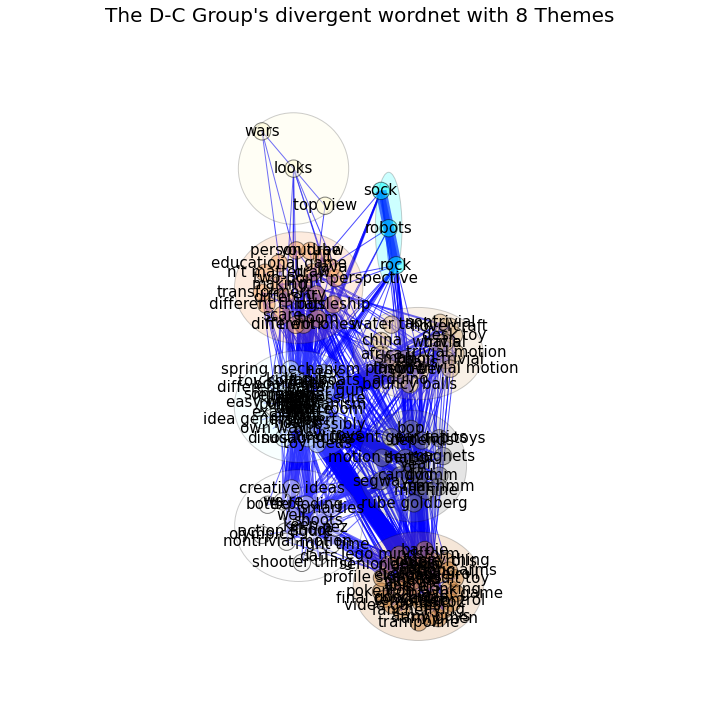

In [23]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="The D-C Group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


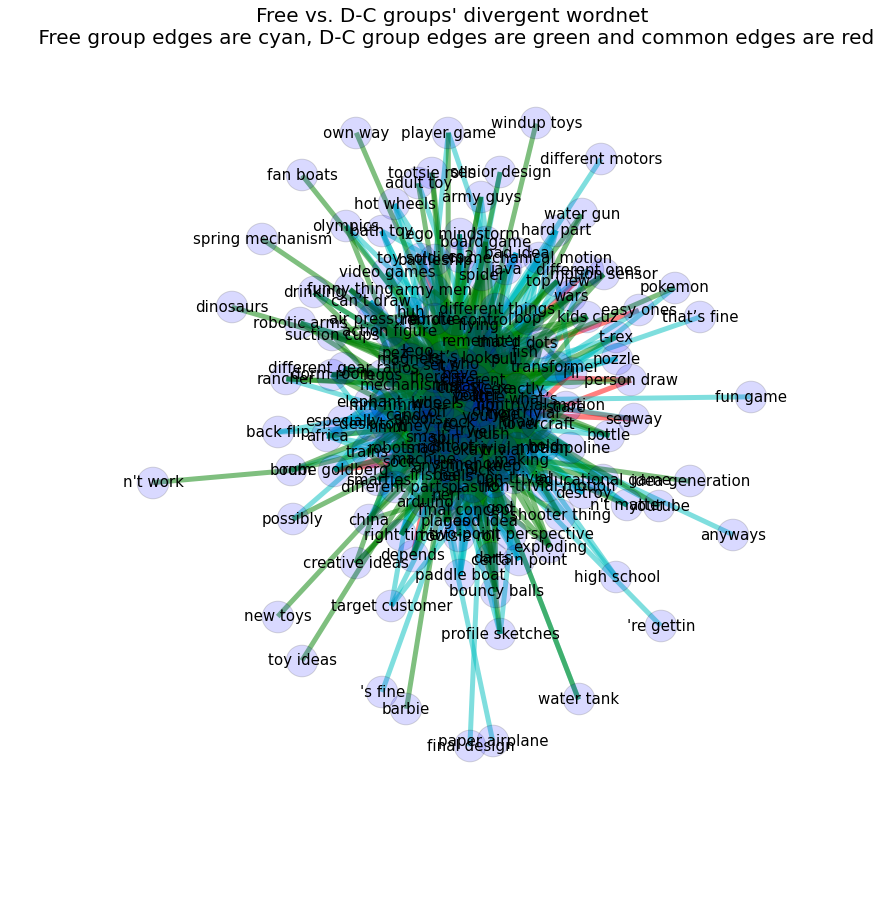

In [25]:
# Plotting the Free brainstorming group vs. the Divergent-Convergent brainstorming group's wordnet

G = nx.Graph()
G.add_edges_from(GFree.edges())
G.add_edges_from(GDC.edges())
pos=nx.spring_layout(G)
# pos=nx.spring_layout(G)
sstt="Free vs. D-C groups' divergent wordnet \n Free group edges are cyan, D-C group edges are green and common edges are red"
plt.figure(figsize=(15,15))
common_edges=set(GFree.edges()).intersection(set(GDC.edges()))
HCandBSedges = list(common_edges)
Cedges=set(GFree.edges()).difference(set(GDC.edges()))
HCedges = list(Cedges)
Sedges=set(GDC.edges()).difference(set(GFree.edges()))
BSedges = list(Sedges)
nx.draw_networkx_nodes(G,pos,withLabels=True,node_color='b',node_size=1000,alpha=0.15)
nx.draw_networkx_edges(G,pos,edgelist=HCandBSedges,width=5,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=HCedges,width=5,alpha=0.5,edge_color='c')
nx.draw_networkx_edges(G,pos,edgelist=BSedges,width=5,alpha=0.5,edge_color='g')
nx.draw_networkx_labels(G,pos=pos,font_size=15)
plt.title(sstt,fontsize=20)
kk=plt.axis('off')